In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-077_nvkw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-077_nvkw
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)
import clip

clip.available_models()

Torch version: 1.13.1+cu116


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
clip_model, preprocess = clip.load("ViT-B/32")
clip_model.eval()
input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
# Function to generate the CLIP embedding of an image
import torch
def clipImage(img):
  imgs = []
  embs = torch.tensor([])
  for i in range(len(img)):
    image = preprocess(img[i]).unsqueeze(0)
    encoded = clip_model.encode_image(image)
    #print(encoded)
    embs = torch.cat((embs, encoded), 0)

  #image = preprocess(img).unsqueeze(0)
  #img_embed = clip_model.encode_image(imgs)
  # image features/emdedding shape is [1,512]
  return embs

In [ ]:
# Function to generate the CLIP embedding of a text
def clipText(text):
  text_tokens = clip.tokenize(text, truncate=True)
  text_features = clip_model.encode_text(text_tokens)
  # text features/emdedding shape is [1,512]
  return text_features

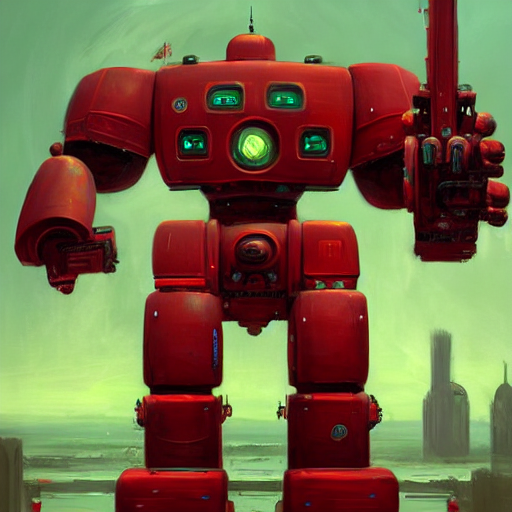

In [ ]:
from PIL import Image

orig0 = Image.open('orig0.png')
test0 = Image.open('ClipInt2StableDiffusion0.png')

display(test0)

In [ ]:
import pandas as pd

texts = pd.read_csv('clip_int_captions.csv')
#texts['captions'][0][2:-2]
texts['prompt'][0]

'doom eternal, game concept art, veins and worms, muscular, crustacean exoskeleton, chiroptera head, chiroptera ears, mecha, ferocious, fierce, hyperrealism, fine details, artstation, cgsociety, zbrush, no background'

Cosine similarities of images and texts

In [ ]:
from torch.nn import CosineSimilarity

cos = CosineSimilarity(dim=1)
print('CLIP scores:')
print('------------')
sum_t2t = 0
sum_i2i = 0
sum_t2i = 0
sum_i2t = 0
for i in range(10):
  # Open images and texts
  original = Image.open('orig'+str(i)+'.png')
  test = Image.open('ClipInt2StableDiffusion'+str(i)+'.png')
  prompt = texts['prompt'][i]
  #caption = "random text test"
  caption = texts['captions'][i][2:-2]

  # CLIP and score
  clip_original = clipImage([original])
  clip_test = clipImage([test])
  clip_prompt = clipText(prompt)
  clip_caption = clipText(caption)
  text2text_score = cos(clip_prompt, clip_caption)
  img2img_score = cos(clip_original, clip_test)
  img2text_score = cos(clip_original, clip_caption)
  text2img_score = cos(clip_prompt, clip_test)
  
  # Sums
  sum_t2t += text2text_score.item()
  sum_i2i += img2img_score.item()
  sum_t2i += text2img_score.item()
  sum_i2t += img2text_score.item()

  # Prints
  #print(prompt)
  #display(original)
  #print(caption)
  #display(test)
  print('img2img: {:.3f}, text2text: {:.3f}, img2text: {:.3f}, text2img: {:.3f}'.format(img2img_score.item(), text2text_score.item(), img2text_score.item(), text2img_score.item()))

CLIP scores:
------------
img2img: 0.823, text2text: 0.554, img2text: 0.322, text2img: 0.135
img2img: 0.913, text2text: 0.752, img2text: 0.343, text2img: 0.293
img2img: 0.731, text2text: 0.598, img2text: 0.348, text2img: 0.224
img2img: 0.835, text2text: 0.583, img2text: 0.346, text2img: 0.254
img2img: 0.921, text2text: 0.594, img2text: 0.331, text2img: 0.278
img2img: 0.895, text2text: 0.563, img2text: 0.364, text2img: 0.261
img2img: 0.784, text2text: 0.601, img2text: 0.302, text2img: 0.246
img2img: 0.826, text2text: 0.522, img2text: 0.335, text2img: 0.275
img2img: 0.727, text2text: 0.397, img2text: 0.324, text2img: 0.242
img2img: 0.785, text2text: 0.579, img2text: 0.332, text2img: 0.254


In [ ]:
clip_original

tensor([])

In [ ]:
print('Averages:')
print('img2img: {:.3f}, text2text: {:.3f}, img2text: {:.3f}, text2img: {:.3f}'.format(sum_i2i/10, sum_t2t/10, sum_i2t/10, sum_t2i/10))

Averages:
img2img: 0.824, text2text: 0.574, img2text: 0.335, text2img: 0.246


In [ ]:
# Open images and texts
orig_images = []
test_images = []
for i in range(10):
  orig_images.append(Image.open('orig'+str(i)+'.png'))
  test_images.append(Image.open('ClipInt2StableDiffusion'+str(i)+'.png'))
prompt = texts['prompt']
#caption = "random text test"
caption = texts['captions'][:].str[2:-2]
print(caption)
t2t_scores = []
i2i_scores = []
# CLIP and score
clip_original = clipImage(orig_images)
clip_test = clipImage(test_images)
clip_prompt = clipText(prompt)
clip_caption = clipText(caption)
with torch.no_grad():
  for i in range(10):
    text2text_score = cos(clip_prompt[i], clip_caption)
    t2t_scores.append(text2text_score.tolist())
    img2img_score = cos(clip_original[i], clip_test)
    i2i_scores.append(img2img_score.tolist())

  #img2text_score = cos(clip_original, clip_caption)
  #text2img_score = cos(clip_prompt, clip_test)

0    painting of a giant red robot with green eyes,...
1    painting of a cemetery with a cemetery in the ...
2     alien creature with red eyes and teeth, an am...
3    close up of an alien creature with large teeth...
4    painting of a factory with smoke coming out of...
5     abandoned building with a ferris wheel in the...
6    demonic looking creature with glowing eyes and...
7    digital painting of a city at night, cyberpunk...
8    room that has a bunch of wires on the floor, c...
9    painting of a building with icicles hanging fr...
Name: captions, dtype: object


In [ ]:
print(clip_original.shape)

torch.Size([10, 512])


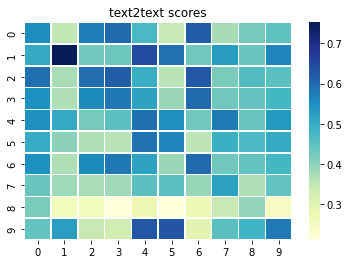

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(np.array(t2t_scores), linewidth=0.5, cmap="YlGnBu")
plt.title('text2text scores')
plt.show()

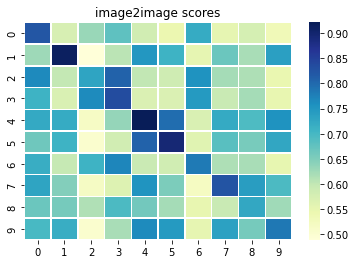

In [ ]:
ax = sns.heatmap(np.array(i2i_scores), linewidth=0.5, cmap="YlGnBu")
plt.title('image2image scores')
plt.show()